## Comandos Linux
Comandos usados para extraer el dataset de Google Drive y remover las clases necesarias según el modelo a probar


In [ ]:
!unzip "/content/drive/MyDrive/ava.zip" -d "/content/ava"

In [ ]:
!unzip "/content/drive/MyDrive/ava_augmented_balanced.zip" -d "/content/ava_augmented_balanced"

In [ ]:
!unzip "/content/drive/MyDrive/ava_augmented_full.zip" -d "/content/ava_augmented_full"

In [ ]:
!rm /content/ava_augmented_full/augmented2/valid/rule_of_thirds/*
!rm /content/ava_augmented_full/augmented2/train/rule_of_thirds/*
!rm /content/ava_augmented_full/augmented2/test/rule_of_thirds/*

!rmdir /content/ava_augmented_full/augmented2/valid/rule_of_thirds
!rmdir /content/ava_augmented_full/augmented2/train/rule_of_thirds
!rmdir /content/ava_augmented_full/augmented2/test/rule_of_thirds

In [ ]:
!rm /content/ava_augmented_full/augmented2/valid/motion_blur/*
!rm /content/ava_augmented_full/augmented2/train/motion_blur/*
!rm /content/ava_augmented_full/augmented2/test/motion_blur/*

!rmdir /content/ava_augmented_full/augmented2/valid/motion_blur
!rmdir /content/ava_augmented_full/augmented2/train/motion_blur
!rmdir /content/ava_augmented_full/augmented2/test/motion_blur

In [ ]:
!rm /content/ava_augmented_full/augmented2/valid/shallow_dof/*
!rm /content/ava_augmented_full/augmented2/train/shallow_dof/*
!rm /content/ava_augmented_full/augmented2/test/shallow_dof/*

!rmdir /content/ava_augmented_full/augmented2/valid/shallow_dof
!rmdir /content/ava_augmented_full/augmented2/train/shallow_dof
!rmdir /content/ava_augmented_full/augmented2/test/shallow_dof

## Inicio del código de Python

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import copy
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
train_path = '/content/ava_augmented_full/augmented2/train'
valid_path = '/content/ava_augmented_full/augmented2/valid'
test_path = '/content/ava_augmented_full/augmented2/test'

In [ ]:
train_batches = ImageDataGenerator(rescale=1.0/255.0) \
                .flow_from_directory(directory=train_path, target_size=(256,256), batch_size=16)
valid_batches = ImageDataGenerator(rescale=1.0/255.0) \
                .flow_from_directory(directory=valid_path, target_size=(256,256), batch_size=16)
test_batches = ImageDataGenerator(rescale=1.0/255.0) \
                .flow_from_directory(directory=test_path, target_size=(256,256), batch_size=100, shuffle=False)

Found 27033 images belonging to 14 classes.
Found 3363 images belonging to 14 classes.
Found 3363 images belonging to 14 classes.


In [ ]:
new_model = load_model('/content/drive/MyDrive/Trained Models/ava_aug_full_14_10_epochs_5635.h5')

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 122880)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 264)               32440584  
_________________________________________________________________
dropout_4 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 264)               69960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 264)              

In [ ]:
predictions = new_model.predict(x=test_batches, verbose=1)

34/34 [==============================] - 46s 791ms/step


In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

Y = label_binarize(test_batches.classes, [0,1,2,3,4,5,6,7,8,9,10,11,12,13])
n_classes = Y.shape[1]
avP = average_precision_score(y_true=Y, y_score=predictions) # Average none to see result per class
print(avP)
print(type(avP))
print(avP.size)

0.606988149416445
<class 'numpy.float64'>
1


In [ ]:
test_batches.classes

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int32)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

{'complementary_colors': 0,
 'dutones': 1,
 'hdr': 2,
 'image_grain': 3,
 'light_on_white': 4,
 'long_exposure': 5,
 'macro': 6,
 'motion_blur': 7,
 'negative_image': 8,
 'rule_of_thirds': 9,
 'shallow_dof': 10,
 'silhouttes': 11,
 'soft_focus': 12,
 'vanishing_point': 13}

In [ ]:
cm_plot_labels = list(test_batches.class_indices.keys())

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]), decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
        
    plt.rcParams["figure.figsize"]=(15, 15)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix
[[0.5  0.   0.01 0.   0.04 0.04 0.14 0.02 0.   0.05 0.1  0.06 0.04 0.  ]
 [0.   0.7  0.   0.09 0.   0.   0.02 0.02 0.06 0.02 0.03 0.05 0.02 0.01]
 [0.03 0.   0.59 0.01 0.03 0.02 0.04 0.03 0.03 0.12 0.04 0.   0.   0.04]
 [0.02 0.04 0.01 0.79 0.   0.   0.01 0.   0.   0.04 0.02 0.01 0.01 0.01]
 [0.01 0.02 0.   0.02 0.89 0.   0.01 0.01 0.01 0.   0.03 0.   0.   0.  ]
 [0.04 0.06 0.06 0.   0.02 0.45 0.05 0.15 0.01 0.05 0.02 0.03 0.02 0.02]
 [0.07 0.01 0.   0.02 0.04 0.01 0.55 0.02 0.01 0.04 0.2  0.   0.01 0.01]
 [0.01 0.04 0.03 0.05 0.03 0.22 0.06 0.29 0.01 0.08 0.08 0.04 0.02 0.03]
 [0.02 0.1  0.01 0.04 0.04 0.02 0.07 0.   0.65 0.01 0.03 0.   0.01 0.  ]
 [0.05 0.05 0.05 0.05 0.04 0.03 0.1  0.01 0.05 0.31 0.12 0.05 0.05 0.05]
 [0.02 0.05 0.01 0.02 0.   0.   0.14 0.01 0.03 0.04 0.62 0.01 0.02 0.02]
 [0.   0.03 0.   0.02 0.01 0.01 0.02 0.   0.01 0.1  0.   0.78 0.   0.02]
 [0.09 0.03 0.02 0.03 0.05 0.05 0.01 0.02 0.02 0.09 0.08 0.04 0.46 0.02]
 [0.03 0.03 0.03 0.02 0

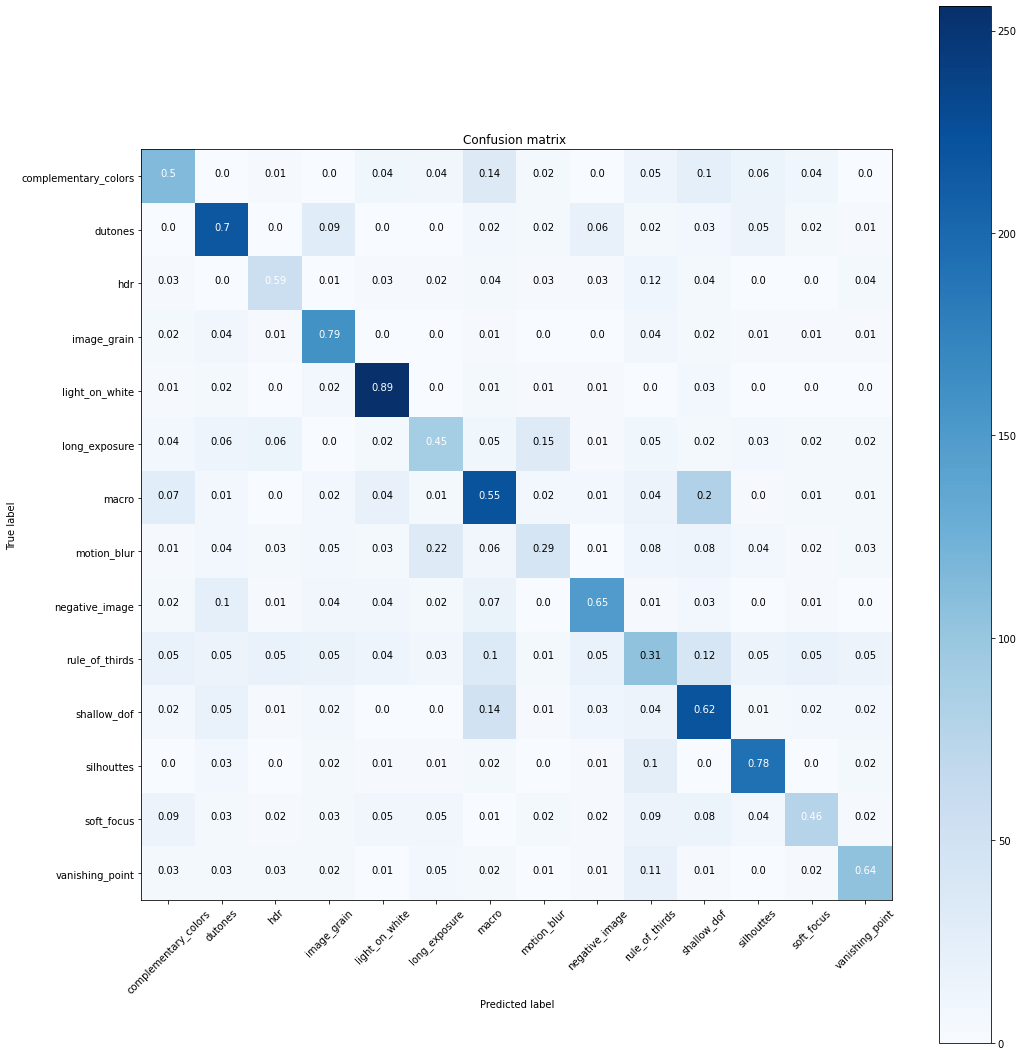

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix ' , normalize=True)